# Flower Recognition CNN Keras

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(os.listdir('/content/drive/MyDrive/flowers'))

['dandelion', 'rose', 'daisy', 'tulip', 'sunflower']


In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

from PIL import Image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetV2B2, MobileNetV2
from tensorflow.keras.optimizers import Optimizer, Adam
from tensorflow.keras.utils import load_img
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import plot_model

In [4]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/flowers/rose'


In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:09<00:00, 83.42it/s] 

764


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:09<00:00, 78.18it/s] 

1497


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:12<00:00, 81.24it/s] 

2481


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1062/1062 [00:13<00:00, 78.21it/s] 

3543


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:09<00:00, 84.10it/s] 

4327


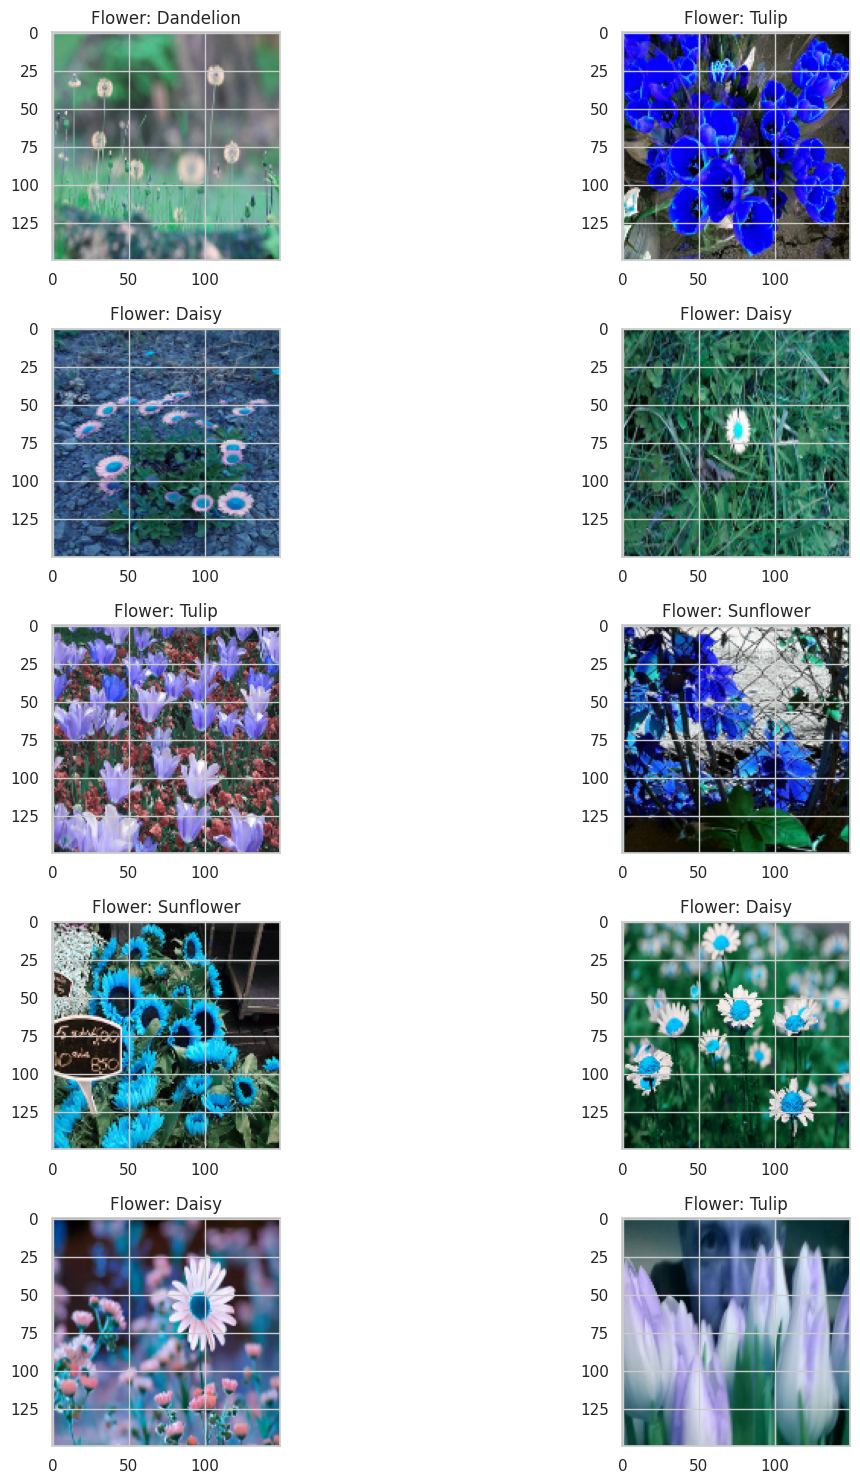

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()


In [13]:
# Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding
le=LabelEncoder()
Z=le.fit_transform(Z)
Y=to_categorical(Z,5)
X=np.array(X)
# X=X/255

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

## Building the ConvNet Model

In [15]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [16]:
batch_size=128
epochs=25

In [17]:
#data augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

tr_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


tr_datagen.fit(x_train)

In [18]:
model.compile(optimizer=Adam(lr=0.009),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

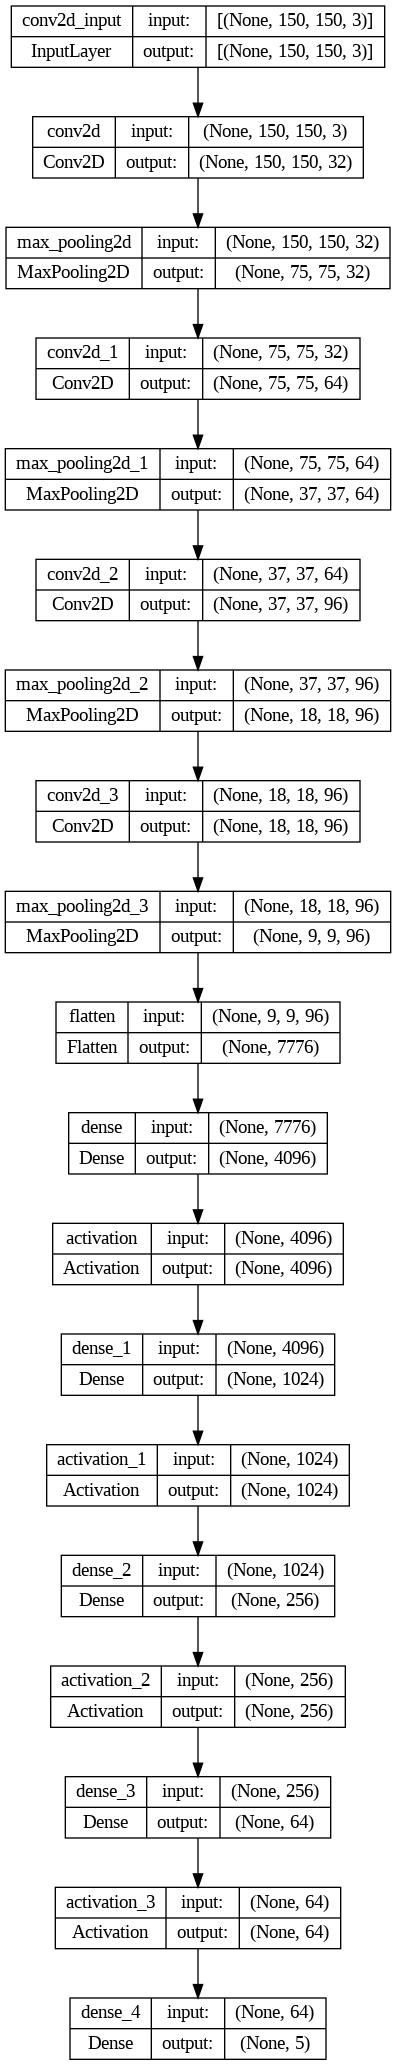

In [20]:
plot_model(model, show_shapes = True)

In [21]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 10, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
25/25 [==============================] - 29s 780ms/step - loss: 30.2429 - accuracy: 0.2364 - val_loss: 1.5210 - val_accuracy: 0.2957
Epoch 2/10
25/25 [==============================] - 17s 696ms/step - loss: 1.4943 - accuracy: 0.3077 - val_loss: 1.4677 - val_accuracy: 0.3567
Epoch 3/10
25/25 [==============================] - 19s 758ms/step - loss: 1.4289 - accuracy: 0.3535 - val_loss: 1.5862 - val_accuracy: 0.3429
Epoch 4/10
25/25 [==============================] - 17s 709ms/step - loss: 1.4995 - accuracy: 0.3115 - val_loss: 1.4419 - val_accuracy: 0.3974
Epoch 5/10
25/25 [==============================] - 17s 689ms/step - loss: 1.4093 - accuracy: 0.3802 - val_loss: 1.3974 - val_accuracy: 0.3919
Epoch 6/10
25/25 [==============================] - 18s 708ms/step - loss: 1.3184 - accuracy: 0.4261 - val_loss: 1.3387 - val_accuracy: 0.4399
Epoch 7/10
25/25 [==============================] - 18s 713ms/step - loss: 1.2960 - accuracy: 0.4398 - val_loss: 1.2934 - val_accuracy: 0.451

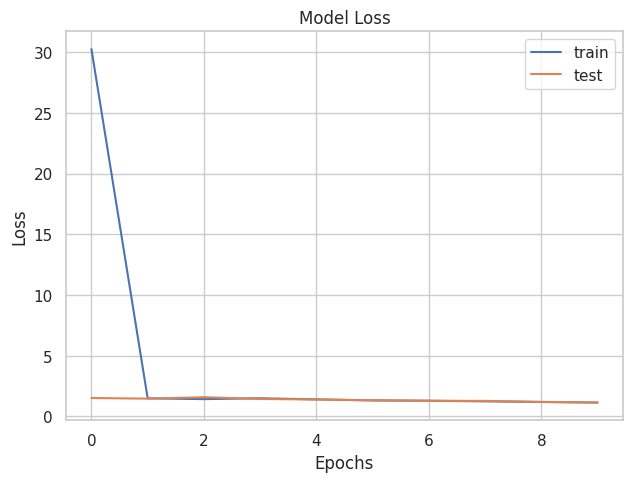

In [22]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

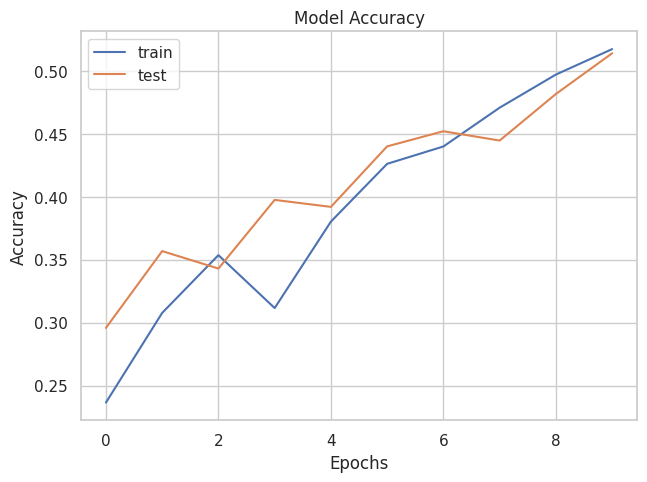

In [23]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


In [24]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_digits)
model_acc*100

34/34 [==============================] - 0s 10ms/step


51.386321626617374

In [25]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)


i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)


##ResNet50 Model

In [26]:
base_resnet50 = ResNet50(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_resnet50.layers:
    layer.trainable = False
# tf.keras.applications.resnet50.preprocess_input(
#     x_train, data_format=None
# );
# tf.keras.applications.resnet50.preprocess_input(
#     x_test, data_format=None
# );

In [27]:

inputs = Input(shape=(150, 150, 3))
x = base_resnet50(inputs, training=False)
x = GlobalAveragePooling2D()(x)
# x = Dense(2048, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
# x = Dense(128, activation = 'relu')(x)
x = Dropout(0.45)(x)
x =Dense(5, activation='sigmoid')(x)

model_resnet50 = Model(inputs, x)
model_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 2565      
                                                             

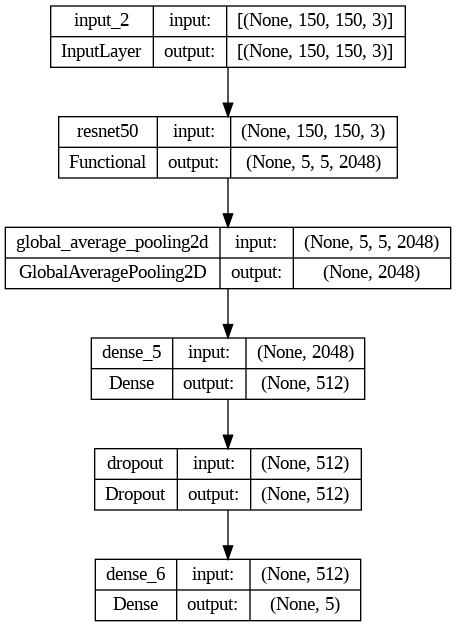

In [28]:
plot_model(model_resnet50, show_shapes = True)

In [29]:
model_resnet50.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_res50 = model_resnet50.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 10,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
25/25 [==============================] - 41s 1s/step - loss: 1.2762 - accuracy: 0.6384 - val_loss: 0.4886 - val_accuracy: 0.8253
Epoch 2/10
25/25 [==============================] - 21s 846ms/step - loss: 0.5165 - accuracy: 0.8046 - val_loss: 0.4101 - val_accuracy: 0.8494
Epoch 3/10
25/25 [==============================] - 30s 1s/step - loss: 0.4165 - accuracy: 0.8457 - val_loss: 0.4127 - val_accuracy: 0.8503
Epoch 4/10
25/25 [==============================] - 33s 1s/step - loss: 0.3864 - accuracy: 0.8575 - val_loss: 0.3849 - val_accuracy: 0.8604
Epoch 5/10
25/25 [==============================] - 19s 777ms/step - loss: 0.3458 - accuracy: 0.8733 - val_loss: 0.3435 - val_accuracy: 0.8789
Epoch 6/10
25/25 [==============================] - 21s 819ms/step - loss: 0.3239 - accuracy: 0.8784 - val_loss: 0.3441 - val_accuracy: 0.8799
Epoch 7/10
25/25 [==============================] - 21s 822ms/step - loss: 0.3082 - accuracy: 0.8864 - val_loss: 0.3676 - val_accuracy: 0.8577
Epoch 8/

In [30]:
acc_rn50 = history_res50.history['accuracy']
val_acc_rn50 = history_res50.history['val_accuracy']
loss_rn50 = history_res50.history['loss']
val_loss_rn50 = history_res50.history['val_loss']

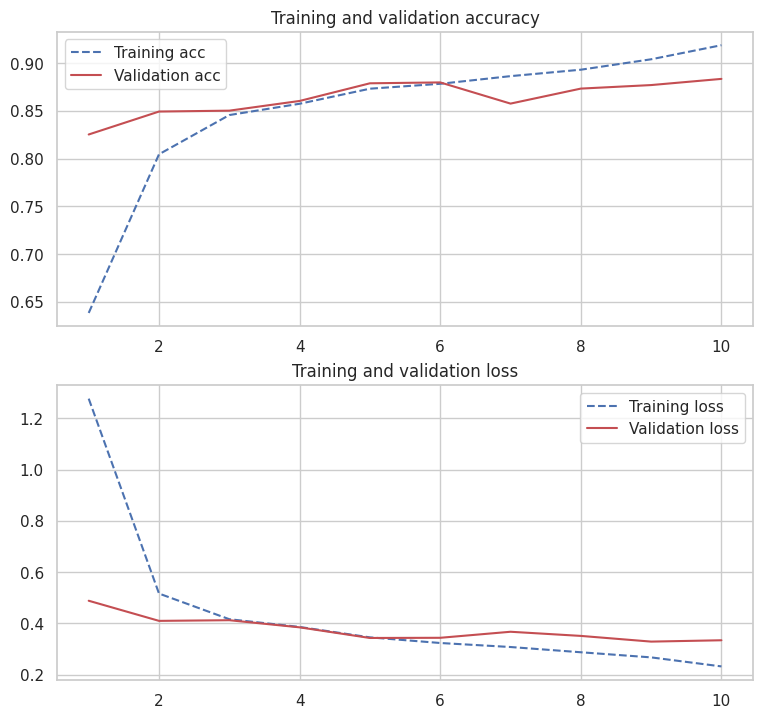

In [31]:
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

epochs = range(1, len(acc_rn50) + 1)
ax[0].plot(epochs, acc_rn50, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc_rn50, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss_rn50, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss_rn50, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()


In [32]:
pred=model_resnet50.predict(x_test)
pred_res50=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

rn_acc = accuracy_score(y_classes,pred_res50)
print(rn_acc)

34/34 [==============================] - 3s 46ms/step
0.8835489833641405


##Efficient Net

In [33]:
base_effnet = EfficientNetV2B2(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_effnet.layers:
    layer.trainable = False

In [34]:
inputs = Input(shape=(150, 150, 3))
x = base_effnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(5, activation='softmax')(x)

model_effnet = Model(inputs, x)
model_effnet.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 efficientnetv2-b2 (Functio  (None, 5, 5, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d_1  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              1442816   
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dense_9 (Dense)             (None, 128)               6566

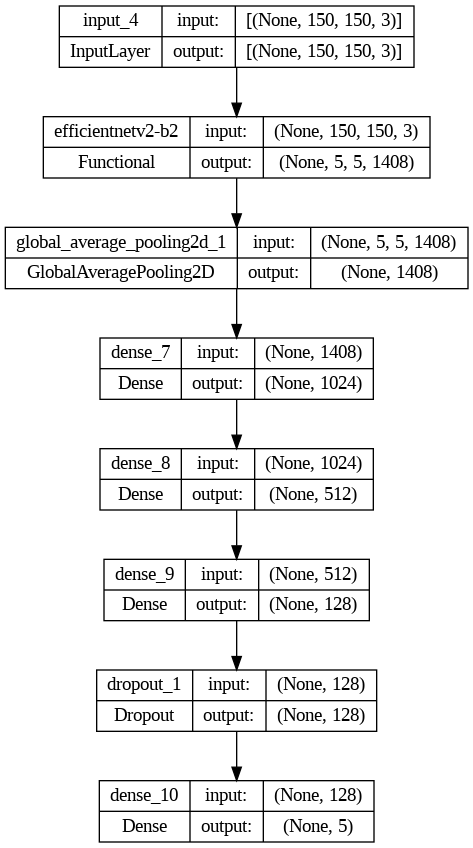

In [35]:
plot_model(model_effnet, show_shapes = True)

In [36]:
batch_size=128
epochs=25

In [37]:
model_effnet.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_ef = model_effnet.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 10,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
25/25 [==============================] - 40s 1s/step - loss: 0.7735 - accuracy: 0.7032 - val_loss: 0.4754 - val_accuracy: 0.8235
Epoch 2/10
25/25 [==============================] - 20s 795ms/step - loss: 0.4214 - accuracy: 0.8441 - val_loss: 0.4504 - val_accuracy: 0.8336
Epoch 3/10
25/25 [==============================] - 19s 780ms/step - loss: 0.3591 - accuracy: 0.8736 - val_loss: 0.3805 - val_accuracy: 0.8558
Epoch 4/10
25/25 [==============================] - 19s 754ms/step - loss: 0.3101 - accuracy: 0.8851 - val_loss: 0.4306 - val_accuracy: 0.8595
Epoch 5/10
25/25 [==============================] - 19s 751ms/step - loss: 0.2468 - accuracy: 0.9092 - val_loss: 0.4207 - val_accuracy: 0.8623
Epoch 6/10
25/25 [==============================] - 19s 750ms/step - loss: 0.2283 - accuracy: 0.9163 - val_loss: 0.4322 - val_accuracy: 0.8604
Epoch 7/10
25/25 [==============================] - 19s 747ms/step - loss: 0.1890 - accuracy: 0.9310 - val_loss: 0.4458 - val_accuracy: 0.8743
Ep

In [38]:
acc_ef = history_ef.history['accuracy']
val_acc_ef = history_ef.history['val_accuracy']
loss_ef = history_ef.history['loss']
val_loss_ef = history_ef.history['val_loss']

In [39]:
pred=model_effnet.predict(x_test)
pred_ef=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_ef)
model_acc


34/34 [==============================] - 3s 36ms/step


0.8724584103512015

##VGG16

In [40]:
from tensorflow.keras.applications import VGG16
base_vgg = VGG16(include_top = False,
                       weights = 'imagenet',
                       input_shape = (150,150,3))

for layer in base_vgg.layers:
    layer.trainable = False

In [41]:
inputs = Input(shape=(150, 150, 3))
x = base_vgg(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x =Dense(5, activation='softmax')(x)

model_vgg = Model(inputs, x)
model_vgg.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 1024)              525312    
                                                                 
 dense_12 (Dense)            (None, 512)               524800    
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                           

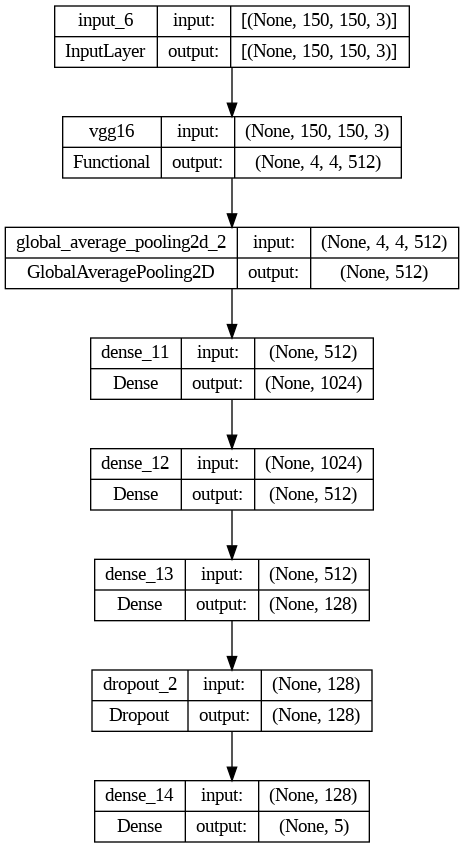

In [42]:
plot_model(model_vgg, show_shapes = True)

In [43]:
batch_size=128
epochs=25

In [44]:
model_vgg.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history_vgg = model_vgg.fit(datagen.flow(x_train,y_train, batch_size=batch_size), epochs = 10,
                              validation_data = (x_test,y_test),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/10
25/25 [==============================] - 44s 2s/step - loss: 2.7039 - accuracy: 0.5268 - val_loss: 0.7973 - val_accuracy: 0.7089
Epoch 2/10
25/25 [==============================] - 22s 862ms/step - loss: 0.6848 - accuracy: 0.7395 - val_loss: 0.6423 - val_accuracy: 0.7874
Epoch 3/10
25/25 [==============================] - 21s 841ms/step - loss: 0.5557 - accuracy: 0.7905 - val_loss: 0.5875 - val_accuracy: 0.8050
Epoch 4/10
25/25 [==============================] - 21s 845ms/step - loss: 0.4737 - accuracy: 0.8181 - val_loss: 0.5603 - val_accuracy: 0.8004
Epoch 5/10
25/25 [==============================] - 22s 881ms/step - loss: 0.4318 - accuracy: 0.8428 - val_loss: 0.5477 - val_accuracy: 0.8068
Epoch 6/10
25/25 [==============================] - 23s 912ms/step - loss: 0.4095 - accuracy: 0.8508 - val_loss: 0.5209 - val_accuracy: 0.8309
Epoch 7/10
25/25 [==============================] - 21s 850ms/step - loss: 0.3797 - accuracy: 0.8582 - val_loss: 0.5555 - val_accuracy: 0.8179
Ep

In [45]:
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']

In [46]:
pred=model_vgg.predict(x_test)
pred_vgg=np.argmax(pred,axis=1)

y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

model_acc = accuracy_score(y_classes,pred_vgg)
model_acc

34/34 [==============================] - 2s 60ms/step


0.8253234750462107

#### CORRECTLY CLASSIFIED FLOWER IMAGES

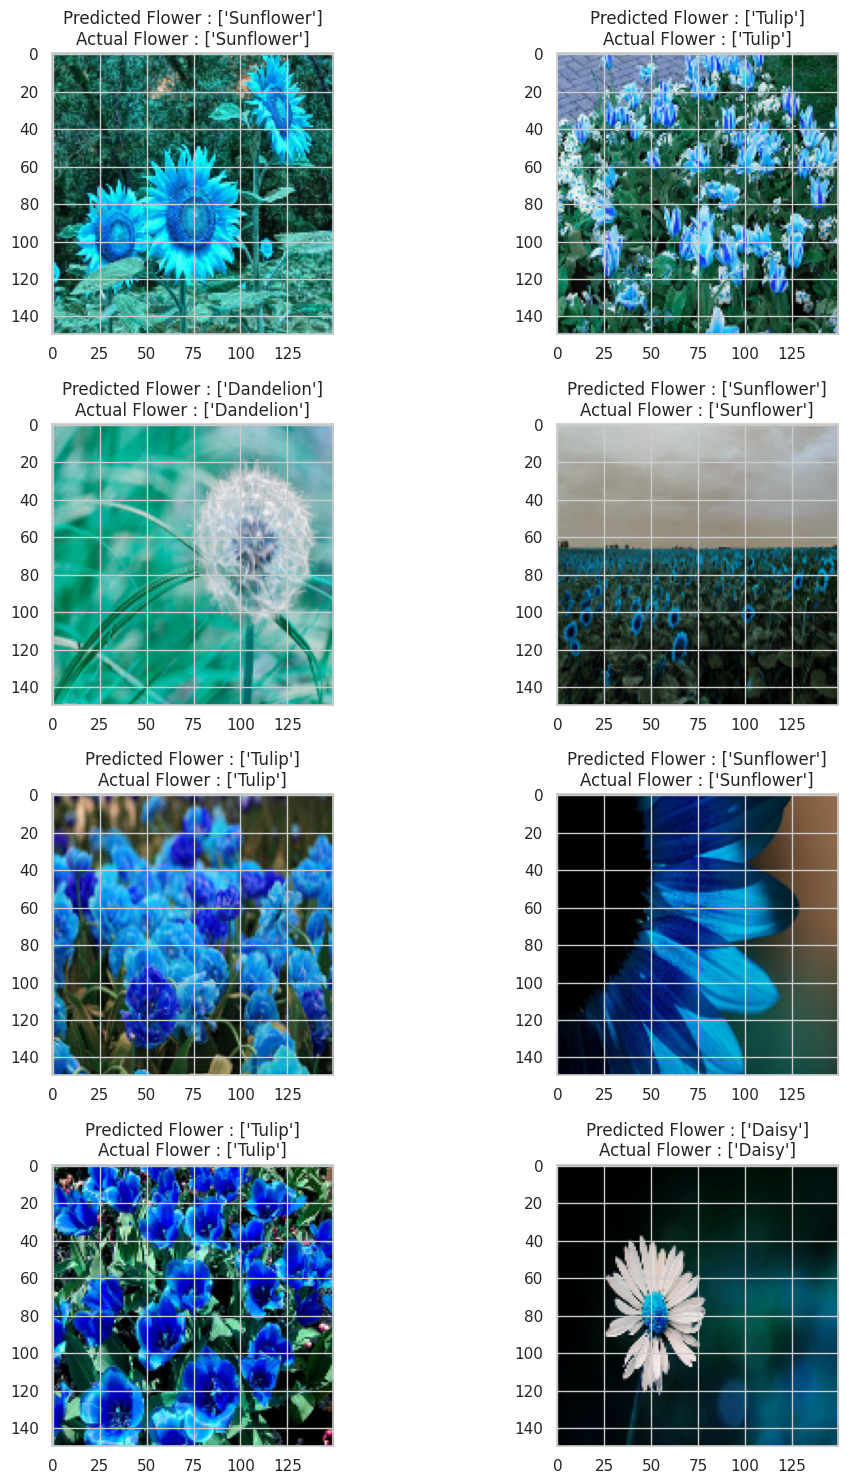

In [47]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(([y_classes[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

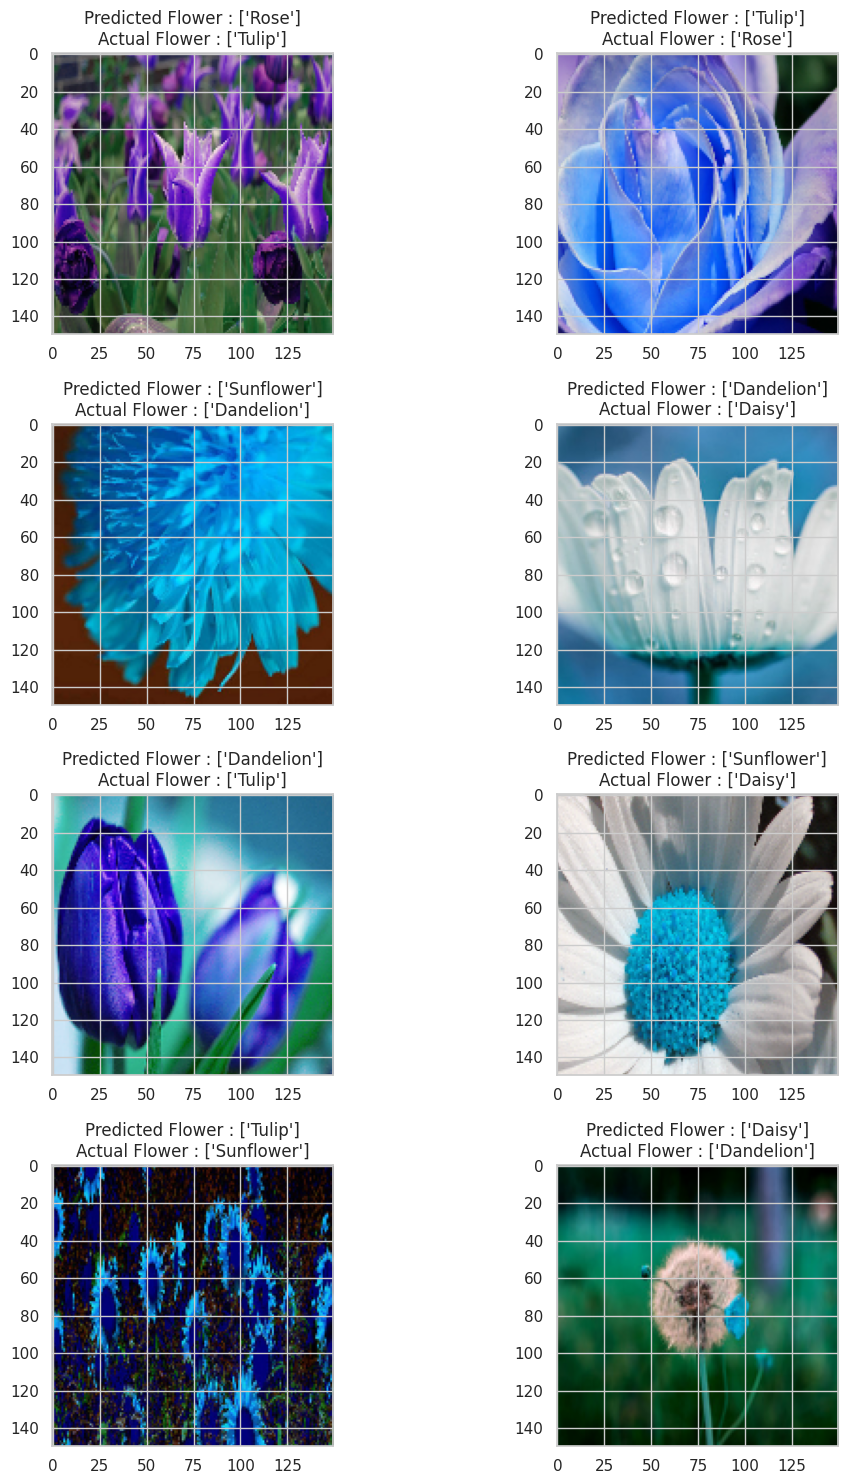

In [48]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(([y_classes[mis_class[count]]]))))
        plt.tight_layout()
        count+=1

In [48]:
import pickle
pickle.dump(model, open('model.pkl','wb'))
pickle.dump(model_resnet50, open('model2.pkl','wb'))
pickle.dump(model_effnet, open('model3.pkl','wb'))
pickle.dump(model_vgg, open('model4.pkl','wb'))